In [1]:
### Packages and data 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import pandas as pd
import seaborn as sns

### Load transcript-to-gene mapping
dic_transcript_gene = {}
with open("/home/mouren/Data/revisions/specificity/list_transript_gene_id_gencodeV41_all_proteincoding.tsv") as file:
    for line in file:
        tx, gene = line.strip().split()[:2]
        dic_transcript_gene[tx] = gene.split(".")[0]

### dic interaction
dic_interaction = {}
with open("/home/mouren/Data/revisions/specificity/robust_associations_exons_genes.txt") as file:
    for line in file:      
        if line.strip().split()[0] not in dic_interaction:
            dic_interaction[line.strip().split()[0]] = [line.strip().split()[1]]
        else:
            dic_interaction[line.strip().split()[0]].append(line.strip().split()[1])
            
### Load exon-to-biotype map
ee_spec_host = {}
ee_spec_target = {}
with open("/home/mouren/Data/revisions/specificity/exons_BioGtex_majority_bilan.tsv") as file:
    for line in file:
        parts = line.strip().split()
        if parts[3] == "TRUE":
            tissue = parts[4]
            ee = parts[0]
            
            #add host
            host_gene = dic_transcript_gene[ee.split("_")[0]]
            if tissue not in ee_spec_host:
                ee_spec_host[tissue] = []
            if host_gene not in ee_spec_host[tissue]:
                ee_spec_host[tissue].append(host_gene)

            #add target
            if ee in dic_interaction:
                if tissue not in ee_spec_target:
                    ee_spec_target[tissue] = []
                for targ in dic_interaction[ee]:
                    if targ not in ee_spec_target[tissue]:
                        ee_spec_target[tissue].append(targ)

In [2]:
### Uhlen all interaction
#The elevated genes were further stratified into “tissue enriched”, “group enriched”, or “tissue enhanced”.

# Dic uhlen gtex
dic_uhlen_gtex = {}
with open("/home/mouren/Data/gene_expr_tendency/dic_gtex_uhlen_normalized_2019.txt") as file:
    for line in file:      
        dic_uhlen_gtex[line.strip().split("\t")[0]] = line.strip().split("\t")[1]

# Uhlen data
df = pd.read_csv("/home/mouren/Data/gene_expr_tendency/uhlen2019_data1.csv", sep="\t", header=0)

#Host
df_host = pd.DataFrame(columns=["Signature","Category","Match"]) 
for tissue,genes in ee_spec_host.items():
    for gene in genes:
        filtered_row = df[df['ensg_id'] == gene]
        if filtered_row.empty:
            continue
        
        #Signature biotype
        entry = [tissue]
        
        #Get category 
        if filtered_row["specificity_category"].values[0] in ["Tissue enriched","Group enriched","Tissue enhanced"]:
            entry.append('Elevated expr.')
        else:
            entry.append(filtered_row["specificity_category"].values[0])

        #Is the gene elevated in the same tissue as the EE gtex signature
        matching = False
        if filtered_row["specificity_category"].values[0] in ["Tissue enriched","Group enriched","Tissue enhanced"]:
            for i in (filtered_row["enhanced_tissues"].values[0]).split(","):
                if dic_uhlen_gtex[i.strip()] == tissue:
                    matching = True
                    break
        entry.append(matching)
        df_host.loc[len(df_host)] = entry

#Target
df_target = pd.DataFrame(columns=["Signature","Category","Match"]) 
for tissue,genes in ee_spec_target.items():
    for gene in genes:
        filtered_row = df[df['ensg_id'] == gene]
        if filtered_row.empty:
            continue
        
        #Signature biotype
        entry = [tissue]
        
        #Get category 
        if filtered_row["specificity_category"].values[0] in ["Tissue enriched","Group enriched","Tissue enhanced"]:
            entry.append('Elevated expr.')
        else:
            entry.append(filtered_row["specificity_category"].values[0])

        #Is the gene elevated in the same tissue as the EE gtex signature
        matching = False
        if filtered_row["specificity_category"].values[0] in ["Tissue enriched","Group enriched","Tissue enhanced"]:
            for i in (filtered_row["enhanced_tissues"].values[0]).split(","):
                if dic_uhlen_gtex[i.strip()] == tissue:
                    matching = True
                    break
        entry.append(matching)
        df_target.loc[len(df_target)] = entry

In [3]:
# Proportion df
def adjusted_category(row):
    if row['Category'] == 'Elevated expr.':
        return 'Elevated expr.\n(matching tissue)' if row['Match'] else 'Elevated expr.'
    else:
        return row['Category']

df_host['AdjustedCategory'] = df_host.apply(adjusted_category, axis=1)
df_target['AdjustedCategory'] = df_target.apply(adjusted_category, axis=1)

# Get counts per Signature and AdjustedCategory
count_df_host = df_host.groupby(['Signature', 'AdjustedCategory']).size().unstack(fill_value=0)
df_host_proportion = count_df_host.div(count_df_host.sum(axis=1), axis=0)
df_host_proportion = df_host_proportion.reset_index()
df_host_proportion = df_host_proportion[df_host_proportion['Signature'] != 'Embryonic']

count_df_target = df_target.groupby(['Signature', 'AdjustedCategory']).size().unstack(fill_value=0)
df_target_proportion = count_df_target.div(count_df_target.sum(axis=1), axis=0)
df_target_proportion = df_target_proportion.reset_index()
df_target_proportion = df_target_proportion[df_target_proportion['Signature'] != 'Embryonic']

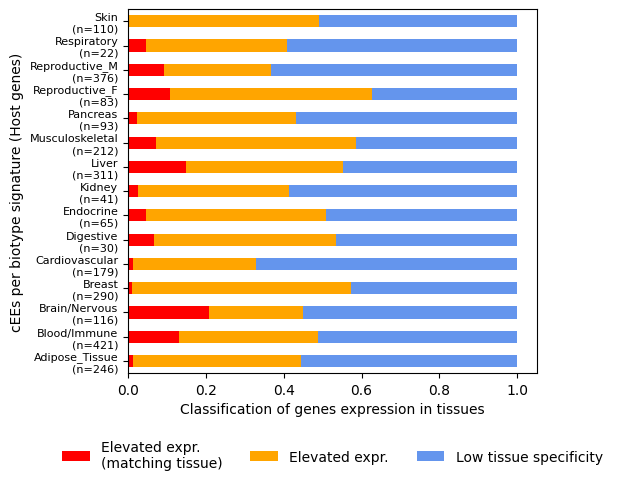

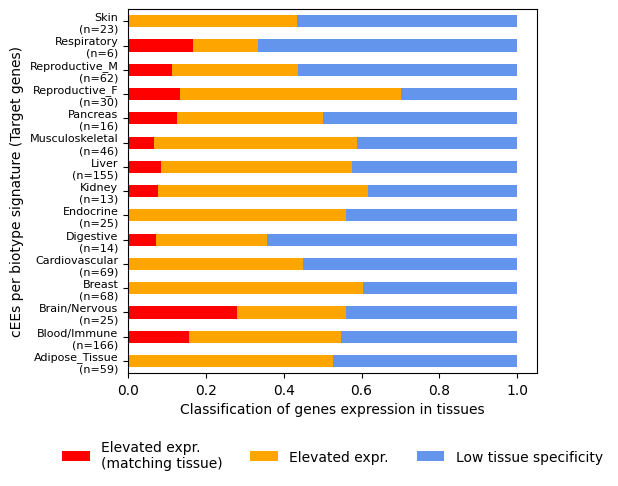

In [6]:
category_order = ['Elevated expr.\n(matching tissue)', 'Elevated expr.', 'Low tissue specificity']

### Host
for col in category_order:
    if col not in df_host_proportion.columns:
        df_host_proportion[col] = 0  # add missing categories with 0s if needed

# Reorder columns
plot_df = df_host_proportion.set_index('Signature')[category_order]

custom_colors = ['red', 'orange', 'cornflowerblue']  # blue, orange, green
#plot_df.plot(kind='barh', stacked=True, color=custom_colors, figsize=(6, 5))
ax = plot_df.plot(kind='barh', stacked=True, color=custom_colors, figsize=(6, 5))

# ---- Add n to y-axis labels ----
# Total counts per Signature (same order as plot_df)
n_counts = count_df_host.loc[plot_df.index].sum(axis=1)

new_labels = [
    f"{sig}\n(n={n_counts[sig]})"
    for sig in plot_df.index
]

ax.set_yticklabels(new_labels, fontsize=8)


plt.xlabel('Classification of genes expression in tissues')
plt.ylabel('cEEs per biotype signature (Host genes)')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(category_order),
    frameon=False
)
plt.tight_layout()

plt.savefig("/home/mouren/Images/revisions/specificity_test/rev_1_pt4_uhlen_specificity_host.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/revisions/specificity_test/rev_1_pt4_uhlen_specificity_host.png", format="png", bbox_inches="tight", dpi=450)

plt.show()

### Target
for col in category_order:
    if col not in df_target_proportion.columns:
        df_target_proportion[col] = 0  # add missing categories with 0s if needed

# Reorder columns
plot_df = df_target_proportion.set_index('Signature')[category_order]

custom_colors = ['red', 'orange', 'cornflowerblue']  # blue, orange, green
#plot_df.plot(kind='barh', stacked=True, color=custom_colors, figsize=(6, 5))
ax = plot_df.plot(kind='barh', stacked=True, color=custom_colors, figsize=(6, 5))

# ---- Add n to y-axis labels ----
n_counts = count_df_target.loc[plot_df.index].sum(axis=1)

new_labels = [
    f"{sig}\n(n={n_counts[sig]})"
    for sig in plot_df.index
]

ax.set_yticklabels(new_labels, fontsize=8)

plt.xlabel('Classification of genes expression in tissues')
plt.ylabel('cEEs per biotype signature (Target genes)')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(category_order),
    frameon=False
)
plt.tight_layout()

plt.savefig("/home/mouren/Images/revisions/specificity_test/rev_1_pt4_uhlen_specificity_target.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/revisions/specificity_test/rev_1_pt4_uhlen_specificity_target.png", format="png", bbox_inches="tight", dpi=450)

plt.show()


In [ ]:
"""The different omics‐based analyses of the human proteome have allowed the classification of protein‐coding genes with regard to tissue‐restricted expression. 
In the analysis performed by the HPA consortium (Fagerberg et al, 2014; Uhlen et al, 2015), a cutoff of 1 FPKM (Hebenstreit et al, 2011) was used to indicate the presence or absence of transcripts for a particular gene in a tissue. 
Based on this definition, all human protein‐coding genes were classified into 

(i) genes with an elevated expression in one or several tissues,  ROUGE / ORANGE

(ii) genes expressed in all analyzed tissues, BLEU
(iii) genes with mixed expression found in several, but not all tissues, BLEU

(iv) genes not detected in any tissues. XXXXXXX
The elevated genes were further stratified into “tissue enriched”, “group enriched”, or “tissue enhanced”.

 The term “tissue specific” was avoided as it depends on the definition of cutoff values, 
 and only few genes, including well‐known proteins such as insulin, PSA, and troponin, were found to be exclusively expressed in a single tissue type (Uhlen et al, 2015). 
 A classification of all protein‐coding genes is shown in Table 2 (cutoff of 0.5 FPKM). Not detected means the data was not present in any of the analyzed tissues (under cutoff)
 
 Uhlén M, Hallström BM, Lindskog C, Mardinoglu A, Pontén F, Nielsen J. Transcriptomics resources of human tissues and organs. Mol Syst Biol. 2016 Apr 4;12(4):862. doi: 10.15252/msb.20155865. PMID: 27044256; PMCID: PMC4848759.

 Specificity order : 
 Tissue enriched, Group enriched, Enhanced, Expressed in all, Mixed, Not detected 	 


      Mathias Uhlen et al. 

,
A genome-wide transcriptomic analysis of protein-coding genes in human blood cells.Science366,eaax9198(2019).DOI:10.1126/science.aax9198

 """

'The different omics‐based analyses of the human proteome have allowed the classification of protein‐coding genes with regard to tissue‐restricted expression. \nIn the analysis performed by the HPA consortium (Fagerberg et al, 2014; Uhlen et al, 2015), a cutoff of 1 FPKM (Hebenstreit et al, 2011) was used to indicate the presence or absence of transcripts for a particular gene in a tissue. \nBased on this definition, all human protein‐coding genes were classified into \n\n(i) genes with an elevated expression in one or several tissues,  ROUGE / ORANGE\n\n(ii) genes expressed in all analyzed tissues, BLEU\n(iii) genes with mixed expression found in several, but not all tissues, BLEU\n\n(iv) genes not detected in any tissues. XXXXXXX\nThe elevated genes were further stratified into “tissue enriched”, “group enriched”, or “tissue enhanced”.\n\n The term “tissue specific” was avoided as it depends on the definition of cutoff values, \n and only few genes, including well‐known proteins such